# Taller 1: Regresión con Random Forest y Gradient Boosting


En este taller se aplicará ensambes de árboles de decisión tipo random forest y gradient boosting a un conjunto de datos de jugadores del video juego FIFA 19. Los datos utilizados son un subconjunto modificado de [este set de datos](https://www.kaggle.com/karangadiya/fifa19) y se encuentran en el archivo `FIFA 19 players.csv`. La tarea a realizar consiste en predecir el salario (wage) de los jugadores.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelBinarizer,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

In [2]:
#Obtenemos los datos
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE' -O players.csv

--2024-03-17 14:43:34--  https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE
Resolving docs.google.com (docs.google.com)... 108.177.96.100, 108.177.96.139, 108.177.96.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.96.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE&export=download [following]
--2024-03-17 14:43:35--  https://drive.usercontent.google.com/download?id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.96.132, 2a00:1450:4013:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.96.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5036558 (4.8M) [application/octet-stream]
Saving to: ‘players.csv’

players.csv         100%[===================>]   4.80M  --.-KB/s    in 0

In [3]:
# Definamos el "random_state" para que los resultados sean reproducibles:
random_state=42

In [4]:
# Cambiemos la fuente de las gráficas de matplotlib:
plt.rc('font', family='serif', size=12)

## Preprocesamiento de datos

In [5]:
# Carguemos los datos:
data = pd.read_csv('players.csv')
data

,Name,Age,Overall,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,L. Messi,31,94,565000,Left,5.0,4.0,4.0,90.0,90.0,...,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,Cristiano Ronaldo,33,94,405000,Right,5.0,4.0,5.0,94.0,94.0,...,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,Neymar Jr,26,92,290000,Right,5.0,5.0,5.0,87.0,87.0,...,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
3,K. De Bruyne,27,91,355000,Right,4.0,5.0,4.0,85.0,85.0,...,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0
4,E. Hazard,27,91,340000,Right,4.0,4.0,4.0,86.0,86.0,...,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,J. Lundstram,19,47,1000,Right,1.0,2.0,2.0,44.0,44.0,...,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0
15922,N. Christoffersson,19,47,1000,Right,1.0,2.0,2.0,47.0,47.0,...,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0
15923,B. Worman,16,47,1000,Right,1.0,3.0,2.0,47.0,47.0,...,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0
15924,D. Walker-Rice,17,47,1000,Right,1.0,3.0,2.0,49.0,49.0,...,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0


In [6]:
# Veamos la descripción del dataset:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15926 entries, 0 to 15925
Data columns (total 63 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      15926 non-null  object 
 1   Age                       15926 non-null  int64  
 2   Overall                   15926 non-null  int64  
 3   Wage                      15926 non-null  int64  
 4   Preferred Foot            15926 non-null  object 
 5   International Reputation  15926 non-null  float64
 6   Weak Foot                 15926 non-null  float64
 7   Skill Moves               15926 non-null  float64
 8   LS                        15926 non-null  float64
 9   ST                        15926 non-null  float64
 10  RS                        15926 non-null  float64
 11  LW                        15926 non-null  float64
 12  LF                        15926 non-null  float64
 13  CF                        15926 non-null  float64
 14  RF    

In [7]:
#Veamos la distribución de las columnas
data.describe()

,Age,Overall,Wage,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,LW,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
count,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,...,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.00000,15926.000000,15926.000000,15926.000000
mean,24.991209,66.446189,10254.866256,1.116037,3.004081,2.533342,59.842647,59.842647,59.842647,61.066809,...,51.446126,59.575411,50.401168,54.844405,55.494726,52.118234,60.34654,51.273703,51.883021,49.593118
std,4.552866,6.809244,22692.769542,0.397762,0.636845,0.618186,9.141407,9.141407,9.141407,9.889102,...,15.718376,14.432944,18.797738,14.665434,12.897478,12.501841,10.14202,17.198926,19.161875,19.162508
min,16.000000,46.000000,1000.000000,1.000000,1.000000,2.000000,33.000000,33.000000,33.000000,27.000000,...,11.000000,13.000000,10.000000,11.000000,12.000000,12.000000,29.00000,10.000000,10.000000,10.000000
25%,21.000000,62.000000,1000.000000,1.000000,3.000000,2.000000,54.000000,54.000000,54.000000,55.000000,...,40.000000,50.000000,34.000000,46.000000,47.000000,42.000000,53.00000,37.000000,35.000000,32.000000
50%,25.000000,66.000000,3000.000000,1.000000,3.000000,2.000000,60.000000,60.000000,60.000000,62.000000,...,54.000000,61.000000,56.000000,57.000000,57.000000,52.000000,61.00000,56.000000,59.000000,56.000000
75%,28.000000,71.000000,10000.000000,1.000000,3.000000,3.000000,66.000000,66.000000,66.000000,68.000000,...,64.000000,70.000000,65.000000,65.000000,65.000000,61.000000,68.00000,65.000000,67.000000,65.000000
max,41.000000,94.000000,565000.000000,5.000000,5.000000,5.000000,94.000000,94.000000,94.000000,94.000000,...,94.000000,95.000000,92.000000,95.000000,94.000000,92.000000,96.00000,94.000000,93.000000,91.000000


In [8]:
# Obtengamos la distribución de valores de la variable `Preferred Foot`:
# tip: pandas function value_counts()
data['Preferred Foot'].value_counts()


Right    11969
Left      3957
Name: Preferred Foot, dtype: int64

In [9]:
# Dado que esta columna es categorica, debemos incluir en el Pipeline su transformación. Utilizaremos
# codificación binaria
#tip: scikit-learn BinaryEncoder -> Igual funcionamiento a OrdinalEncoder
encoder = OrdinalEncoder()



## Regresión

**Nota:** Dejaremos la coulmna `Name` en el datafrme para poder identificar a los jugadores, pero **la debemos excluir** al definir las variables `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, and `y_test`.

In [10]:
# Separemos los datos en conjuntos de entrenamiento (80 %) y prueba (20 %):
X = data.drop('Wage', axis=1)
y = data.Wage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [12]:
#Definimos las transformaciones
cat_cols = X_train.select_dtypes(include=object).drop('Name', axis=1).columns
num_cols = X_train.select_dtypes(include=np.number).columns

categorical_transformer = encoder
numerical_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

#Definimos nuestro regresor
rf_base = RandomForestRegressor(random_state=random_state)
gb_base = GradientBoostingRegressor(random_state=random_state)

#Definimos los pipelines
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('modeling', rf_base)
])
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('modeling', gb_base)
])

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    'modeling__n_estimators': [80, 100, 120],
    'modeling__max_depth': [2, 3, 4],
}

# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)

In [13]:
%%time
# Entrenemos el random forest:
rf.fit(X_train, y_train)
# Entrenemos el gradient boosting:
gb.fit(X_train, y_train)

CPU times: user 5min 3s, sys: 405 ms, total: 5min 4s
Wall time: 5min 18s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         Index(['Age', 'Overall', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
       'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing'...
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle'],
      dtype='object')),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         Index(['Preferred Foot'], dtype='object'))])),
                                       ('modeling',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'modeling__max_depth': [2, 3, 4],
                         'modeling__n_estimators': [80, 100, 120]})

In [14]:
print(rf.best_params_)
print(gb.best_params_)

{'modeling__max_depth': 4, 'modeling__n_estimators': 80}
{'modeling__max_depth': 2, 'modeling__n_estimators': 80}


In [15]:
# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_train, y_train)}')
    print(f'MAE: {mean_absolute_error(y_train, model.predict(X_train))}')
    print('\n')

print("Test set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_test, y_test)}')
    print(f'MAE: {mean_absolute_error(y_test, model.predict(X_test))}')
    print('\n')

Train set
Model: Random Forest
R^2: 0.8105563848680551
MAE: 4635.925469309786


Model: Gradient Boosting
R^2: 0.8300412159747863
MAE: 4524.055201514008


Test set
Model: Random Forest
R^2: 0.7544503172592294
MAE: 4974.956338509563


Model: Gradient Boosting
R^2: 0.760314624721701
MAE: 4960.840899522222




In [16]:
# Veamos los datos junto con las predicciones:
pd.concat([
    data.drop(columns='Wage').reset_index(drop=True),
    data['Wage'].reset_index(drop=True),
    pd.DataFrame({'rf_predicted_wage': rf.predict(data.drop(columns=['Name', 'Wage']))}),
    pd.DataFrame({'gb_predicted_wage': gb.predict(data.drop(columns=['Name', 'Wage']))})
], axis=1)

,Name,Age,Overall,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,...,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Wage,rf_predicted_wage,gb_predicted_wage
0,L. Messi,31,94,Left,5.0,4.0,4.0,90.0,90.0,90.0,...,94.0,94.0,75.0,96.0,33.0,28.0,26.0,565000,475613.815789,542931.128828
1,Cristiano Ronaldo,33,94,Right,5.0,4.0,5.0,94.0,94.0,94.0,...,95.0,82.0,85.0,95.0,28.0,31.0,23.0,405000,396438.782100,405204.821144
2,Neymar Jr,26,92,Right,5.0,5.0,5.0,87.0,87.0,87.0,...,89.0,87.0,81.0,94.0,27.0,24.0,33.0,290000,309030.352702,312599.150404
3,K. De Bruyne,27,91,Right,4.0,5.0,4.0,85.0,85.0,85.0,...,87.0,94.0,79.0,88.0,68.0,58.0,51.0,355000,342905.154431,363912.010183
4,E. Hazard,27,91,Right,4.0,4.0,4.0,86.0,86.0,86.0,...,87.0,89.0,86.0,91.0,34.0,27.0,22.0,340000,321257.841255,340203.378002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,J. Lundstram,19,47,Right,1.0,2.0,2.0,44.0,44.0,44.0,...,39.0,52.0,43.0,45.0,40.0,48.0,47.0,1000,2023.581381,2292.593726
15922,N. Christoffersson,19,47,Right,1.0,2.0,2.0,47.0,47.0,47.0,...,46.0,33.0,43.0,42.0,22.0,15.0,19.0,1000,2023.581381,2292.593726
15923,B. Worman,16,47,Right,1.0,3.0,2.0,47.0,47.0,47.0,...,48.0,43.0,55.0,41.0,32.0,13.0,11.0,1000,2023.581381,2292.593726
15924,D. Walker-Rice,17,47,Right,1.0,3.0,2.0,49.0,49.0,49.0,...,44.0,47.0,50.0,46.0,20.0,25.0,27.0,1000,2023.581381,2292.593726


Explicabilidad

In [17]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.7 MB/s eta 0:00:00


In [18]:
import shap
from IPython.display import HTML

In [19]:
# Entrenamos nuestro pipeline con los mejores parámetros encontrados en la validación cruzada
pipeline_gb.set_params(**gb.best_params_)
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['Age', 'Overall', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
       'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPas...
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle'],
      dtype='object')),
                                                 ('cat', OrdinalEncoder(),
                                                  Index(['Preferred Foot'], dtype='object'))])),
                ('modeling',
                 GradientBoostingRegressor(max_depth=2, n_estimators=80,
                                           random_state=42))])

In [28]:
# Aplicamos el preproceso a los datos
X_train_preprocessed = pipeline_gb.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = pipeline_gb.named_steps['preprocessor'].transform(X_test)

In [56]:
# Entrenemos nuestro modelo de explicabilidad
gb_explainer = shap.TreeExplainer(pipeline_gb.named_steps["modeling"])
train_gb_shap_values = gb_explainer.shap_values(X_train_preprocessed)
test_gb_shap_values = gb_explainer.shap_values(X_test_preprocessed)


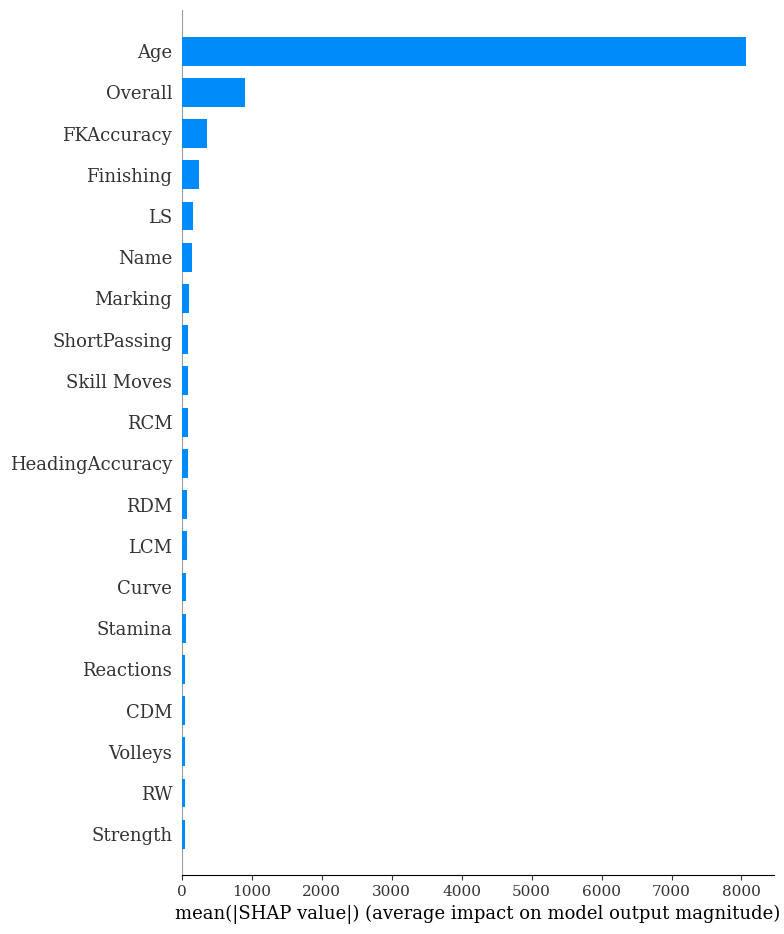

In [32]:
# Summary plot
shap.summary_plot(train_gb_shap_values, X_train_preprocessed, plot_type="bar", feature_names=list(X_train.columns))

In [44]:
muestra_ejemplo

,Name,Age,Overall,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
12543,I. Hajtić,20,61,Right,1.0,3.0,2.0,40.0,40.0,40.0,...,22.0,62.0,57.0,23.0,30.0,33.0,43.0,60.0,64.0,58.0


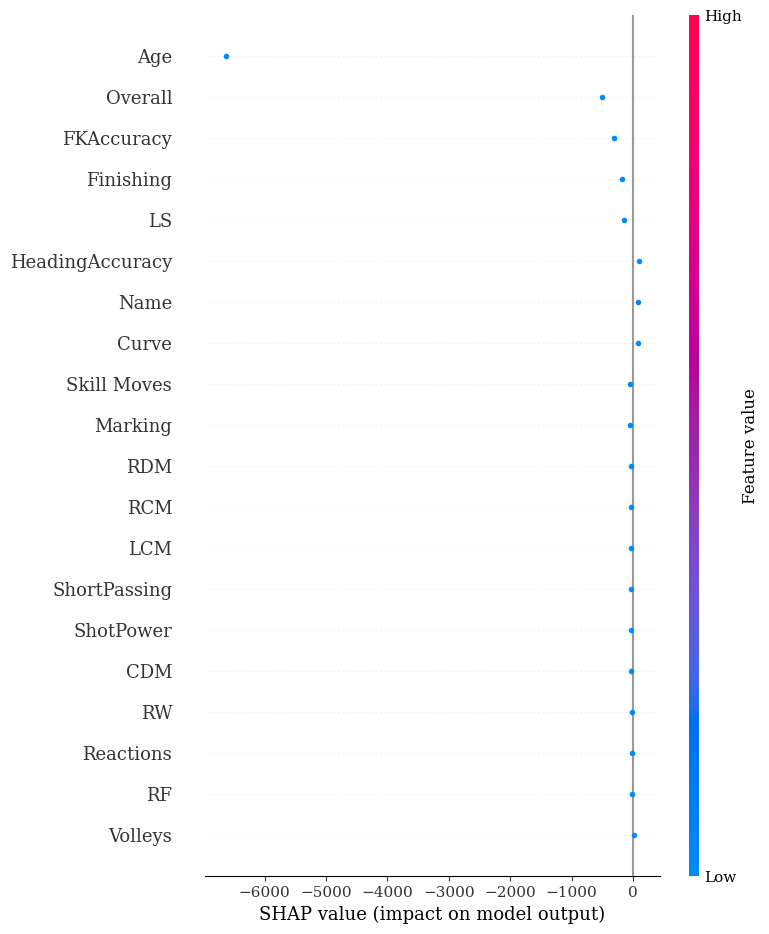

In [51]:
# Grafiquemos los valores SHAP para un ejemplo del conjunto de test
muestra_ejemplo = pipeline_gb.named_steps['preprocessor'].transform(X_test.sample(1, random_state = 101))
muestra_ejemplo_shap_values = gb_explainer.shap_values(muestra_ejemplo)
# # Crear un gráfico de resumen de Shapley
shap.summary_plot(muestra_ejemplo_shap_values, muestra_ejemplo, feature_names=list(X_train.columns))

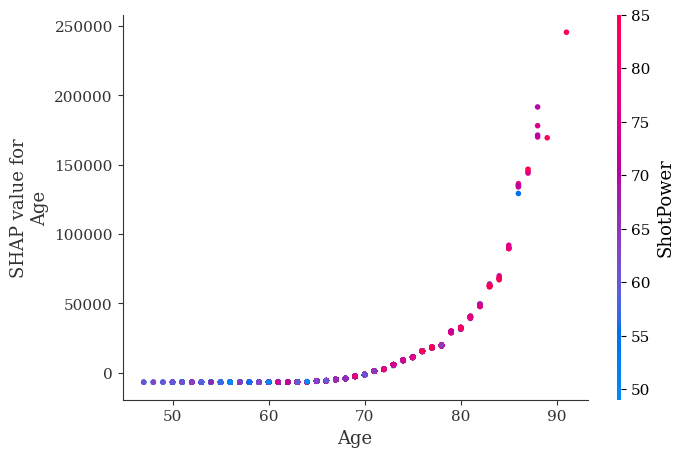

In [59]:
# Grafiquemos la dependencia de los valores SHAP con la variable "Age"

shap.dependence_plot('Age', test_gb_shap_values, X_test_preprocessed, feature_names=list(X_train.columns))

